In [2]:
!pip install split-folders
import warnings
warnings.filterwarnings('ignore')
import os    
import cv2
import time
import torch 
import random 
import pathlib    
import numpy as np  
import pandas as pd 
import seaborn as sns 
import torch.nn as nn   
import torch.utils.data
from datetime import datetime  
from termcolor import colored  
import matplotlib.pyplot as plt  
import matplotlib.image as mpimg
from torch.utils.data import DataLoader
from PIL import Image
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix, classification_report
import splitfolders 
sns.set_style('darkgrid')

In [6]:
def get_device():
    if torch.cuda.is_available:
        return torch.device('cuda')
    else:
        return torch.device('cpu')

get_device()

device(type='cuda')

In [7]:
dataset_path = '/kaggle/input/kidney-stone-classification-and-object-detection'
data = dataset_path

In [8]:
def file_count(data_path):
    for Folder in os.listdir(dataset_path):
        FolderPath = os.path.join(dataset_path, Folder)
        if os.path.isdir(FolderPath):
            count = len(os.listdir(FolderPath))
            print(f'Number of files in {Folder}: {count}')

file_count(dataset_path)

Number of files in stone: 5002
Number of files in Normal: 4414


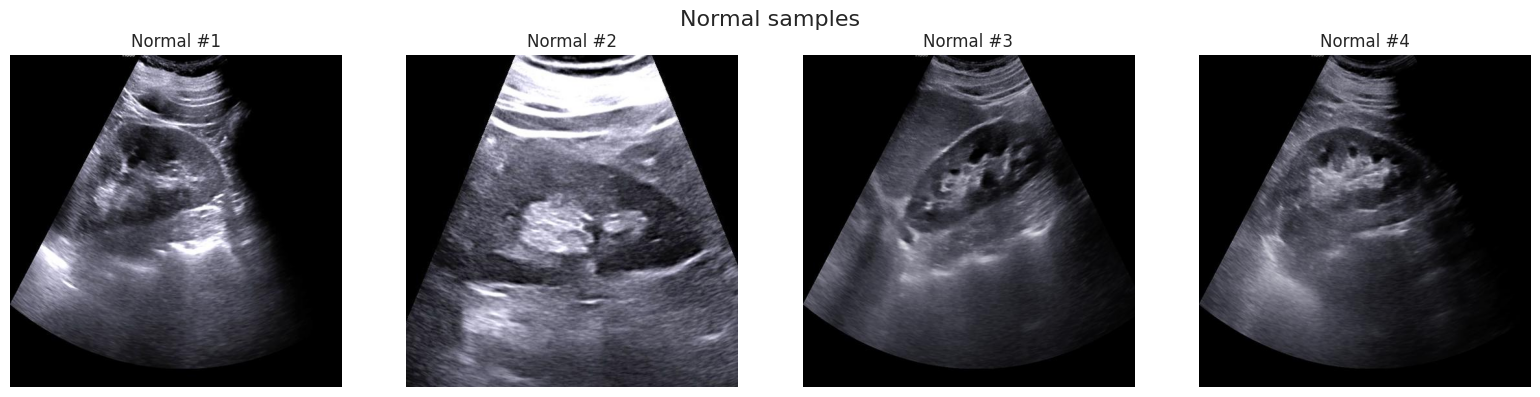

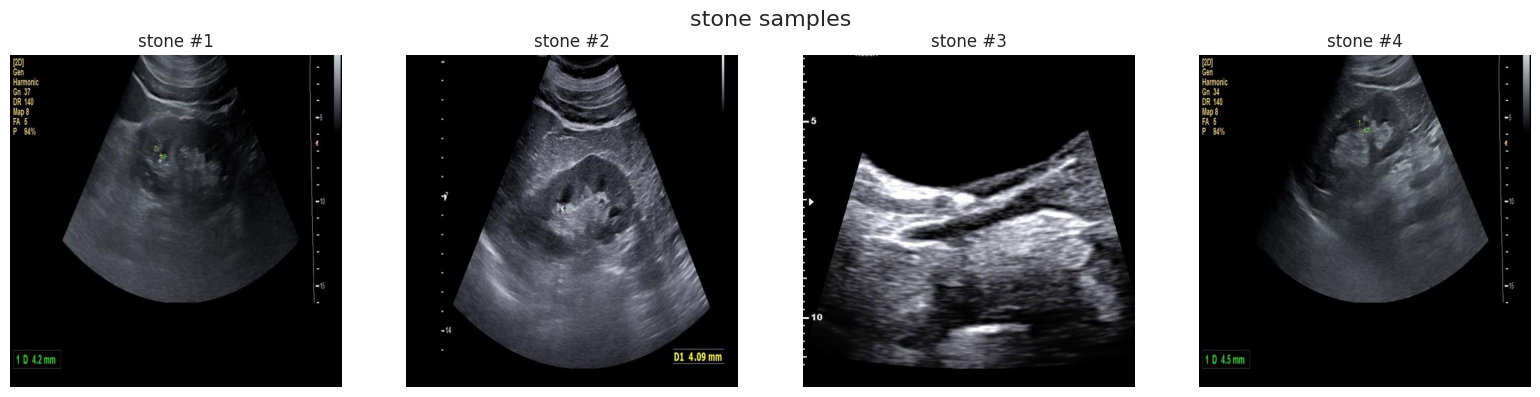

In [9]:
class_names = ['Normal', 'stone'] 

def show_images(dataset_path, class_names):
    for class_name in class_names:
        class_path = os.path.join(dataset_path, class_name)
        images = os.listdir(class_path)[:4]  # Get first 4 images
        plt.figure(figsize=(16, 4))  # One row, 4 columns

        for i, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = mpimg.imread(img_path)

            plt.subplot(1, 4, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'{class_name} #{i+1}')

        plt.suptitle(f'{class_name} samples', fontsize=16)
        plt.tight_layout()
        plt.show()

show_images(dataset_path, class_names)


In [14]:
# creating Train, Val and Test directories
splitfolders.ratio(
    input=dataset_path,
    output="imgs",
    seed=42,
    ratio=(0.7, 0.2, 0.1),
)

dir2 = '/kaggle/working/imgs'
dir2 = pathlib.Path(dir2)

Copying files: 9416 files [00:36, 257.21 files/s] 


In [20]:
train_path = dir2 / 'train'
val_path = dir2 / 'val'
test_path = dir2 / 'test'

In [19]:
transform = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
])

In [22]:
train = torchvision.datasets.ImageFolder(root=train_path,transform = transform)
val = torchvision.datasets.ImageFolder(root=val_path,transform = transform)
test = torchvision.datasets.ImageFolder(root=test_path,transform = transform)

In [24]:
train_data = DataLoader(train, batch_size=64, shuffle=True)
val_data = DataLoader(val, batch_size=64, shuffle=True)
test_data = DataLoader(test, batch_size=64, shuffle=True)

In [25]:
# Efficiently move data to device (CPU or GPU)
def to_device(data, device):
    """Recursively move tensors to the specified device."""
    if isinstance(data, (list, tuple)):
        return type(data)(to_device(x, device) for x in data)
    return data.to(device, non_blocking=True)


class DeviceDataLoader:
    """A wrapper to move batches from a DataLoader to a target device."""
    
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __iter__(self):
        return (to_device(batch, self.device) for batch in self.dataloader)

    def __len__(self):
        return len(self.dataloader)

In [27]:
device = get_device()
device

device(type='cuda')

In [28]:
# Moving data into GPU, WrappedDataLoader
train_data = DeviceDataLoader(train_data, device)
valid_data = DeviceDataLoader(val_data, device)
test_data = DeviceDataLoader(test_data, device)

In [29]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [30]:
class CNN(nn.Module):
    def __init__(self,classes):
        super(CNN, self).__init__()
        
        # Convolutional Layers (Feature Extractors)
        self.conv_layers = nn.Sequential(
            # First Convolutional Layer: Input channels = 3 (RGB), Output channels = 32
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.ReLU(),  # Apply ReLU activation function to introduce non-linearity
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=(2, 2)),  # Reduce spatial dimensions by half
            nn.BatchNorm2d(32),  # Normalize the outputs of the previous layer
            nn.Dropout(p=0.5),
            
            # Second Convolutional Layer: Input channels = 32, Output channels = 64
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),  # Apply ReLU activation function
            nn.MaxPool2d(kernel_size=(2, 2)),  # Further reduce spatial dimensions
            nn.BatchNorm2d(64),  # Normalize the outputs of the previous layer
            nn.Dropout(p=0.2),
            
            # Third Convolutional Layer: Input channels = 64, Output channels = 128
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),  # Apply ReLU activation function
            nn.MaxPool2d(kernel_size=(2, 2)),  # Further reduce spatial dimensions
            nn.BatchNorm2d(128),  # Normalize the outputs of the previous layer
        )
        

        
        # Fully Connected (Dense) Layers (Classifier)
        self.dense_layers = nn.Sequential(
            nn.Linear(107648, 128),  # Fully connected layer: From flattened features to 128 units
            nn.ReLU(),  # Apply ReLU activation function
            nn.Dropout(0.5),
            nn.Linear(128, 64),  # Fully connected layer: From 128 units to 64 units
            nn.ReLU(),  # Apply ReLU activation function
            nn.Linear(64, classes)  # Final layer: From 64 units to the number of classes (e.g., 5 for this model)
        )
    
    # Define the forward pass of the network
    def forward(self, X):
        out = self.conv_layers(X)  # Pass input through the convolutional layers
        out = out.view(out.size(0), -1)  # Flatten the output from the convolutional layers
        out = self.dense_layers(out)  # Pass the flattened output through the dense layers
        return out  # Return the final output (logits or class scores)

model = CNN(5) 
model.to(device)
model


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dense_layers

In [31]:
print("Model Device:", next(model.parameters()).device)
images, labels = next(iter(train_data))  # Get one batch
print("Batch Device:", images.device)

Model Device: cuda:0
Batch Device: cuda:0


In [32]:
images = images.to(device, dtype=torch.float32)  # Ensures images are float tensors
labels = labels.to(device, dtype=torch.long)  # Required for CrossEntropyLoss

In [34]:
# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Number of epochs for training
num_epochs = 10

# Initialize arrays to store loss and accuracy for each epoch
train_losses = np.zeros(num_epochs)
val_losses = np.zeros(num_epochs)
train_accs = np.zeros(num_epochs)
val_accs = np.zeros(num_epochs)

# DeviceDataLoader ensures data is loaded onto the correct device
train_data = DeviceDataLoader(train_data, device)
valid_data = DeviceDataLoader(valid_data, device)

# Training loop over the specified number of epochs
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    t0 = datetime.now()

    # Initialize variables for tracking losses and accuracy
    train_loss = 0
    train_correct = 0
    train_total = 0

    # Training phase
    for images, labels in train_data:
        optimizer.zero_grad()

        # Forward pass: Compute predicted labels by passing images to the model
        y_pred = model(images)
        loss = criterion(y_pred, labels)  # Compute the loss

        # Backward pass: Compute gradients
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        train_loss += loss.item()
        _, predicted_labels = torch.max(y_pred, 1)
        train_correct += (predicted_labels == labels).sum().item()
        train_total += labels.size(0)

    # Average the losses and compute accuracy for training
    train_losses[epoch] = train_loss / len(train_data)
    train_accs[epoch] = train_correct / train_total

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # No need to track gradients during validation
        for images, labels in valid_data:
            # Forward pass: Compute predicted labels for validation set
            y_pred = model(images)
            loss = criterion(y_pred, labels)

            # Accumulate validation loss and accuracy
            val_loss += loss.item()
            _, predicted_labels = torch.max(y_pred, 1)
            val_correct += (predicted_labels == labels).sum().item()
            val_total += labels.size(0)

    # Average the losses and compute accuracy for validation
    val_losses[epoch] = val_loss / len(val_data)
    val_accs[epoch] = val_correct / val_total
    duration = datetime.now() - t0

    # Print the metrics for the current epoch
    print(f'Epoch [{epoch+1}/{num_epochs}] - '
          f'Train Loss: {train_losses[epoch]:.4f}, Train Accuracy: {train_accs[epoch]:.4f} | '
          f'Val Loss: {val_losses[epoch]:.4f}, Val Accuracy: {val_accs[epoch]:.4f} | '
          f'Duration: {duration}')

# saving the model after training
torch.save(model.state_dict(), "KSCM.pth")

Epoch [1/10] - Train Loss: 0.0394, Train Accuracy: 0.9912 | Val Loss: 0.0532, Val Accuracy: 0.9936 | Duration: 0:00:48.786490
Epoch [2/10] - Train Loss: 0.0246, Train Accuracy: 0.9947 | Val Loss: 0.0547, Val Accuracy: 0.9894 | Duration: 0:00:48.754570
Epoch [3/10] - Train Loss: 0.0235, Train Accuracy: 0.9954 | Val Loss: 0.0298, Val Accuracy: 0.9920 | Duration: 0:00:48.792751
Epoch [4/10] - Train Loss: 0.0198, Train Accuracy: 0.9950 | Val Loss: 0.0167, Val Accuracy: 0.9936 | Duration: 0:00:48.250597
Epoch [5/10] - Train Loss: 0.0134, Train Accuracy: 0.9962 | Val Loss: 0.0013, Val Accuracy: 0.9995 | Duration: 0:00:48.432831
Epoch [6/10] - Train Loss: 0.0195, Train Accuracy: 0.9956 | Val Loss: 0.0079, Val Accuracy: 0.9984 | Duration: 0:00:48.580648
Epoch [7/10] - Train Loss: 0.0101, Train Accuracy: 0.9976 | Val Loss: 0.0038, Val Accuracy: 0.9989 | Duration: 0:00:48.622769
Epoch [8/10] - Train Loss: 0.0082, Train Accuracy: 0.9980 | Val Loss: 0.0102, Val Accuracy: 0.9968 | Duration: 0:00:48

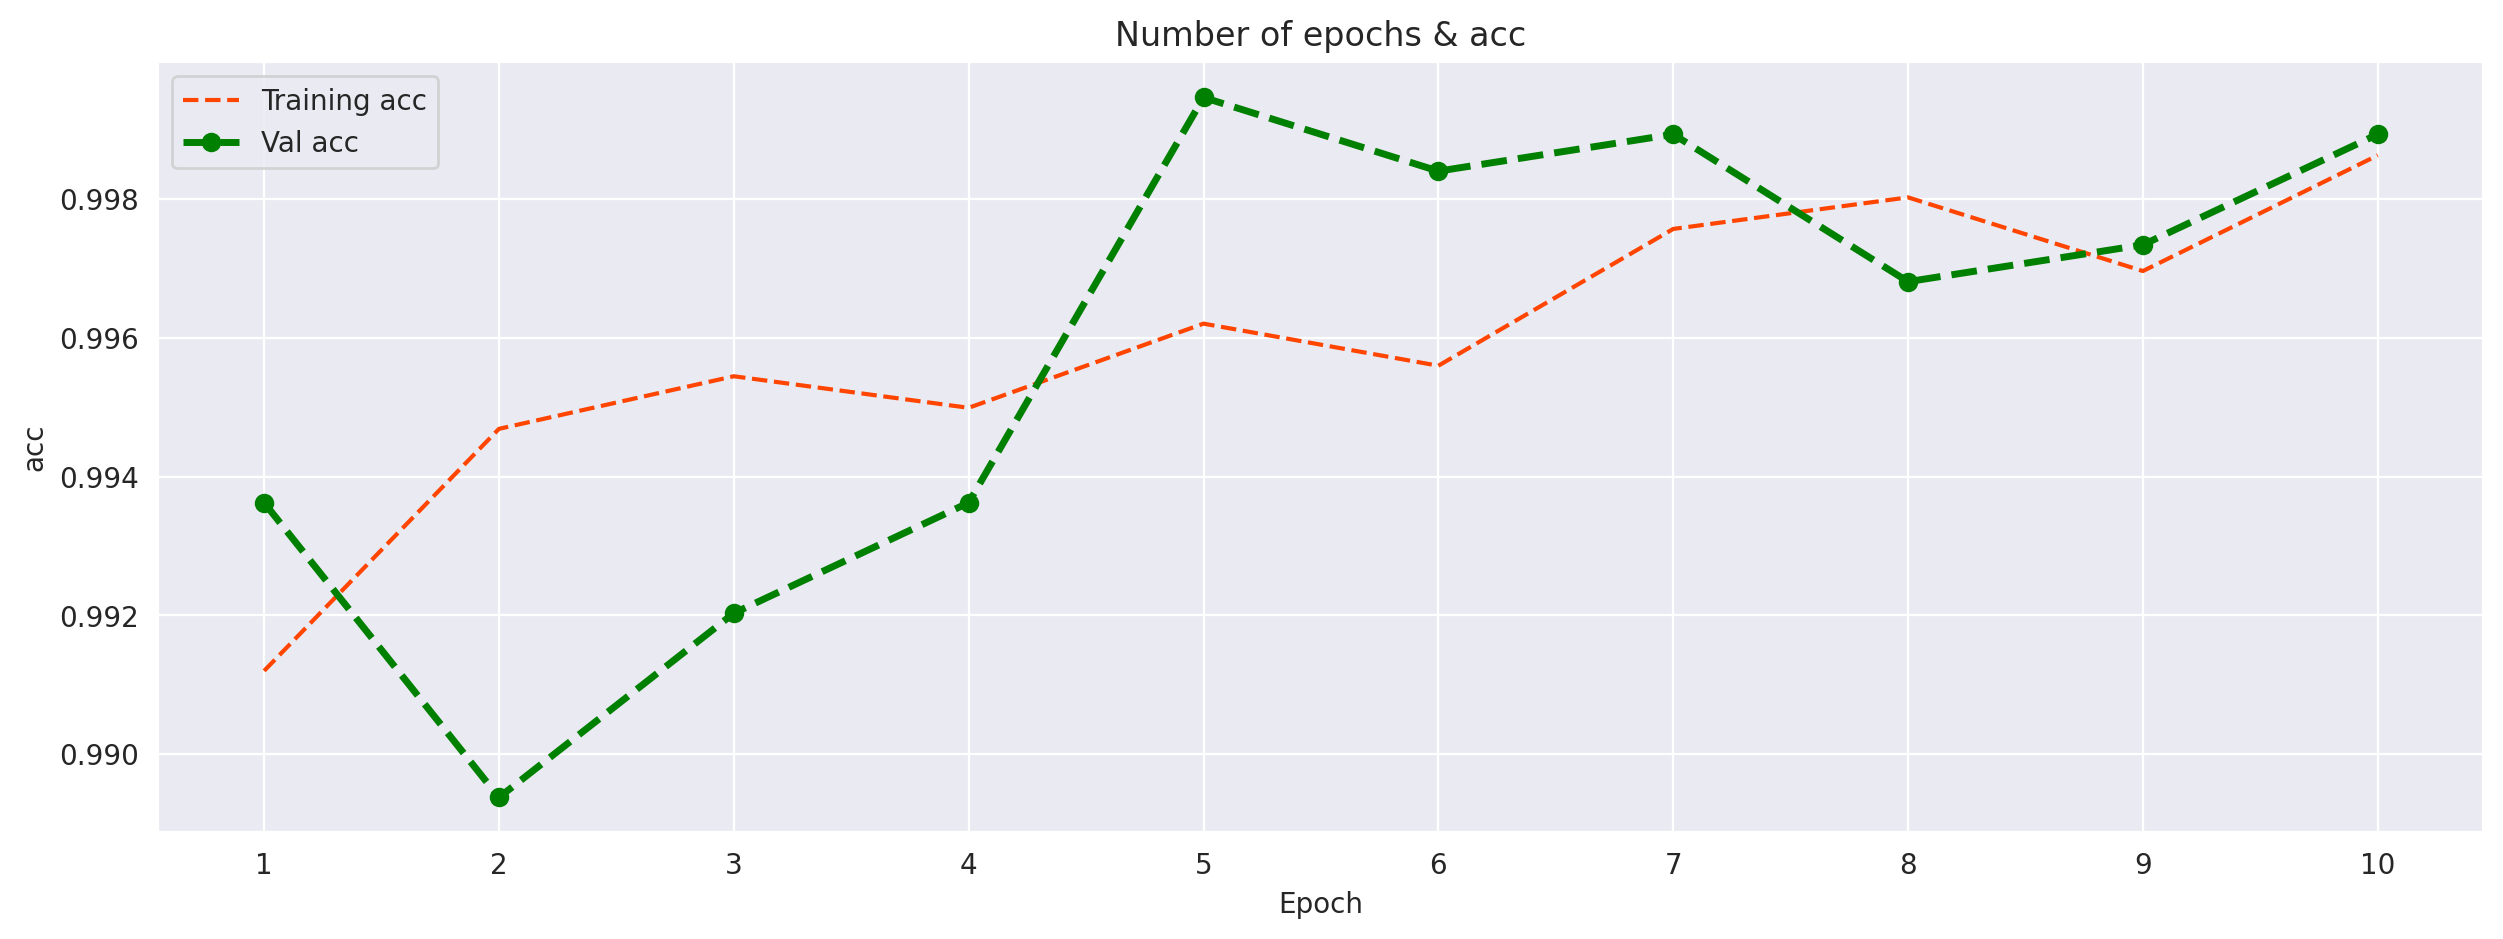

In [37]:
epoch_count = range(1,11)
plt.figure(figsize=(15,5), dpi=200)
plt.plot(epoch_count, train_accs, 'r--', color= 'orangered')
plt.plot(epoch_count, val_accs, '--bo',color= 'green', linewidth = '2.5', label='line with marker')
plt.legend(['Training acc', 'Val acc'])
plt.title('Number of epochs & acc')
plt.xlabel('Epoch')
plt.ylabel('acc')
plt.xticks(np.arange(1,11,1))
plt.show();

Excellent Overall Performance

    Both training and validation accuracy are consistently above 99%, indicating that the model is learning well and generalizing successfully on the validation set.

    There is no major sign of underfitting.

Validation Accuracy Exceeds Training Accuracy

    From epochs 5 to 10, the validation accuracy is sometimes higher than training accuracy, which is uncommon and usually a good sign.

    This may be due to regularization, data augmentation, or just a well-distributed validation set.

Mild Instability in Validation Accuracy

    Validation accuracy shows fluctuations, especially around epochs 2, 5, and 8.

    This could suggest small batch size, or variability in the validation dataset. Consider using a larger validation set or smoothing with moving averages.

No Overfitting Observed

    Since the training and validation curves track closely without diverging, there’s no evidence of overfitting yet.

    If training continues for more epochs, monitor the gap to ensure this remains true.

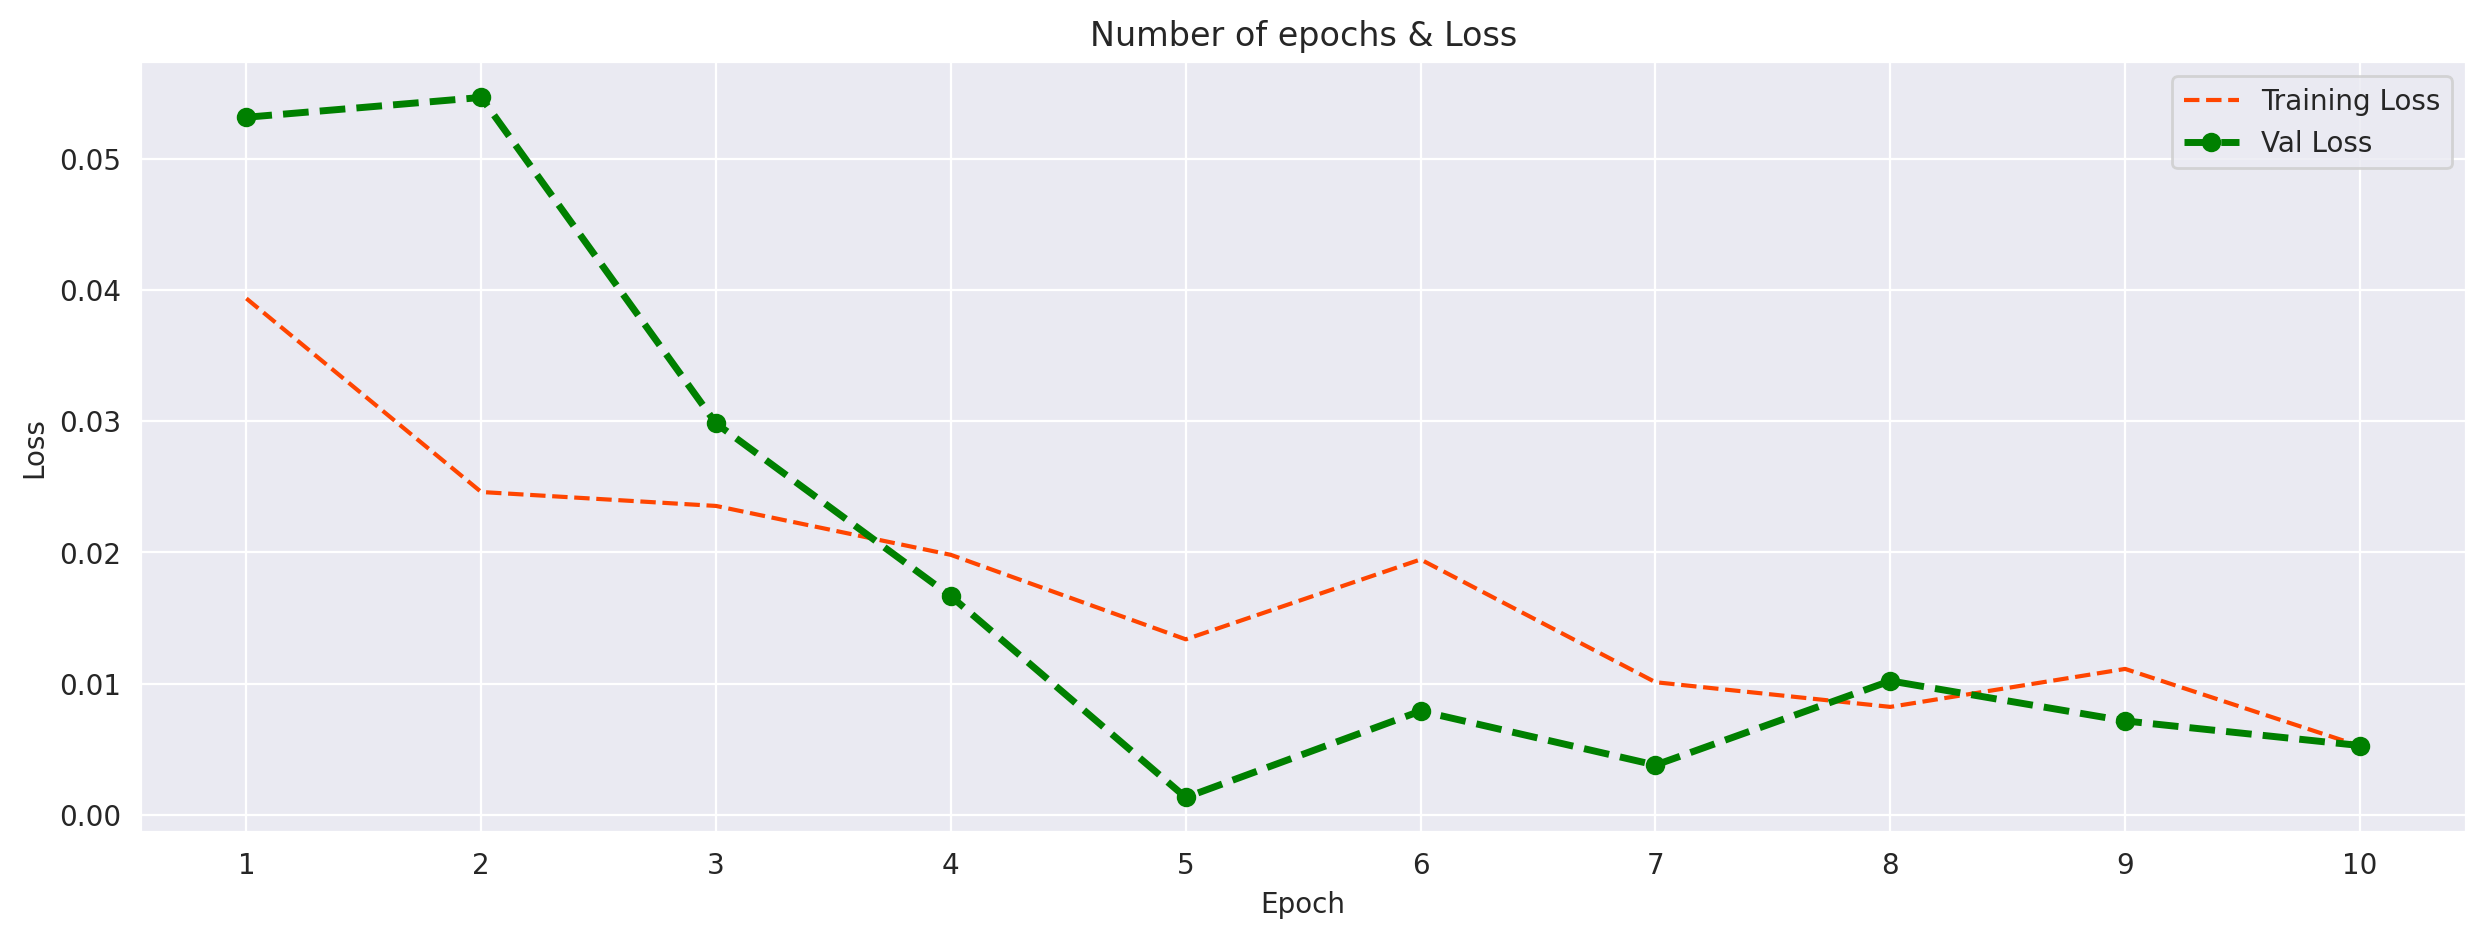

In [38]:
epoch_count = range(1,11)
plt.figure(figsize=(15,5), dpi=200)
plt.plot(epoch_count, train_losses, 'r--', color= 'orangered')
plt.plot(epoch_count, val_losses, '--bo',color= 'green', linewidth = '2.5', label='line with marker')
plt.legend(['Training Loss', 'Val Loss'])
plt.title('Number of epochs & Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(1,11,1))
plt.show();

In [41]:
all_predictions = []
with torch.no_grad():  # Disable gradient calculation
    for batch in test_data:
        inputs = batch[0]  # Get inputs from the batch
        outputs = model(inputs)  # Get model predictions
        _, predicted = torch.max(outputs, 1)  # Get the predicted class (if classification)
        all_predictions.extend(predicted.cpu().numpy()) 

predictions = np.array(all_predictions)

In [40]:
def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    """
    Plots a confusion matrix as a heatmap.

    Parameters:
    - y_true: True labels.
    - y_pred: Predicted labels.
    - class_names: List of class names.
    - title: Title for the plot.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(15, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

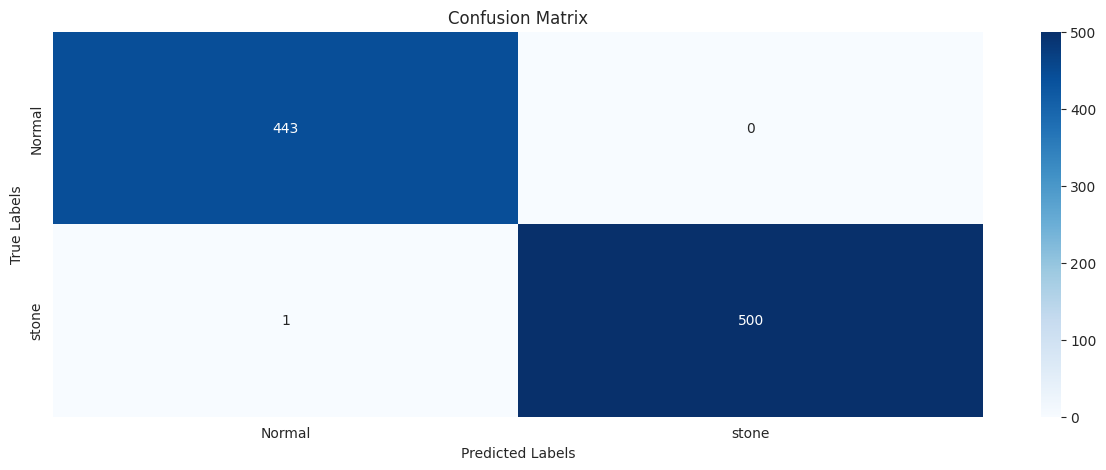

In [42]:
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_data:
        inputs, labels = batch  # Ensure batch contains both images & labels
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get predicted class

        y_true.extend(labels.cpu().numpy())  # Convert to NumPy
        y_pred.extend(predicted.cpu().numpy())  # Convert to NumPy

# Define class names
class_names = ['Normal', 'stone']  

# Call confusion matrix function
plot_confusion_matrix(y_true, y_pred, class_names)

In [43]:
from sklearn.metrics import classification_report

def print_evaluation_metrics(y_true, y_pred, class_names):
    """
    Prints a classification report with precision, recall, F1-score, and support for each class.

    Parameters:
    - y_true: True labels.
    - y_pred: Predicted labels.
    - class_names: List of class names.
    """
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("Model Evaluation Metrics:\n")
    print(report)

# Training Metrics
print("Test Metrics:")
print_evaluation_metrics(y_true, y_pred, class_names)

Test Metrics:
Model Evaluation Metrics:

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       443
       stone       1.00      1.00      1.00       501

    accuracy                           1.00       944
   macro avg       1.00      1.00      1.00       944
weighted avg       1.00      1.00      1.00       944



Perfect Overall Accuracy (99.89%)

    The model predicted 943 out of 944 samples correctly.

    This results in a 99.89% accuracy, which is near-perfect and confirms that the model generalizes well.

Precision, Recall, F1 = 1.00 (Rounded)

    All three main metrics—precision, recall, and F1-score—are 1.00 for both classes.

    Since you're classifying Normal vs Stone, this shows no false positives or false negatives worth reporting (except the single misclassified stone).

Confusion Matrix Confirms Only 1 Misclassification

    Only 1 stone image was misclassified as normal, which is incredibly good in medical imaging, where false negatives are critical.

No Bias Toward Any Class

        Metrics are equally strong for both 'Normal' and 'Stone', indicating no class imbalance issue or bias in the predictions.

